In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import random

In [47]:
IMAGE_SIZE = 16
CATEGORY = 4
N_FILTERS =32
RESIDUAL_BLOCKS = 5
EPOCHS = 80

In [48]:
(train,_),(_,_) = datasets.fashion_mnist.load_data()

In [49]:
# Preprocess the Data
def preprocess(image):
    image_out = np.expand_dims(image, -1)
    image_out = tf.image.resize(image_out, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    # we want model to predict 0,1,2,3 i.e. 4 class rather than 256 class to keep computation simple
    image_out = (image_out/(256/CATEGORY)).astype(int)
    image_input = image_out.astype("float32")
    # input image will be scaled between 0 to 1
    image_input = image_input/CATEGORY
    return image_input, image_out

In [50]:
train_x, train_y = preprocess(train)

In [51]:
def plot_image(images, num=10, fig_size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):

    plt.figure(figsize=fig_size)
    index = images.shape[0]
    random_numbers = random.sample(range(0, index), num)
    for i,j in enumerate(random_numbers):
        _ = plt.subplot(1, num, i+1)
        plt.imshow(images[j].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

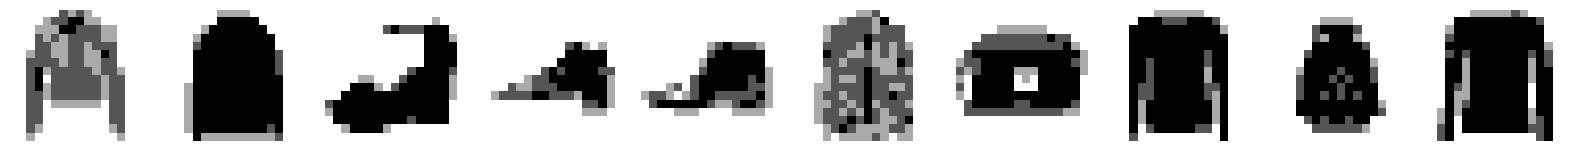

In [54]:
plot_image(train_x)

SUBCLASS KERAS LAYER CLASS TO CREATE MASKEDCONV2D

In [55]:
class MaskedConv2D(tf.keras.layers.Layer):
  def __init__(self, mask_type="A",**kwargs):
    super(MaskedConv2D, self).__init__()
    self.mask_type = mask_type
    self.conv = tf.keras.layers.Conv2D(**kwargs)
  def build(self, input_shape):
    self.conv.build(input_shape)
    kernel_shape = self.conv.kernel.shape
    self.mask = np.zeros(shape=kernel_shape)
    self.mask[:kernel_shape[0]//2,...] = 1.0
    self.mask[kernel_shape[0]//2,:kernel_shape[1]//2,...] = 1.0
    if self.mask_type =="B":
      self.mask[kernel_shape[0]//2,kernel_shape[1]//2,...] = 1.0
  def call(self, inputs):
    self.conv.kernel.assign(self.conv.kernel * self.mask)
    return self.conv(inputs)
  def get_config(self):
    config = super().get_config()
    config.update({
        "mask_type": self.mask_type
    })
    return config



## CREATE RESIDUAL BLOCK - INSPIRED BY RESNET

In [56]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self,n_filter,**kwargs):
    super(ResidualBlock, self).__init__(**kwargs)
    self.conv1 = layers.Conv2D(filters = n_filter,kernel_size =1, activation='relu')
    self.pixelmask_conv = MaskedConv2D(mask_type="B",filters = n_filter, kernel_size =3, padding = 'same',activation='relu')
    self.conv2 = layers.Conv2D(filters = n_filter, kernel_size =1, activation='relu')
  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pixelmask_conv(x)
    x = self.conv2(x)
    return layers.add([x,inputs])

  def get_config(self):
    config = super().get_config()
    config.update({
        "n_filter": self.n_filter
    })
    return config

In [57]:
class pixel_cnn(tf.keras.Model):
  def __init__(self,num_residual_block = 5,num_mask_block =2, n_filters = N_FILTERS,n_channel =4,**kwargs):
    super(pixel_cnn, self).__init__(**kwargs)
    self.channel = n_channel
    self.num = num_residual_block
    self.num_mask = num_mask_block
    self.n_filters = n_filters
    self.maskconv1 = MaskedConv2D(mask_type="A",filters = self.n_filters,kernel_size =7,activation='relu',padding='same')
    self.res_blocks = []
    for i in range(self.num):
      self.res_blocks.append(ResidualBlock(self.n_filters))
    self.mask_blocks = []
    for j in range(self.num_mask):
      self.mask_blocks.append(MaskedConv2D(mask_type="B", filters=self.n_filters, kernel_size=1, activation='relu', padding='valid'))
    self.conv_output = tf.keras.layers.Conv2D(filters = self.channel,kernel_size =1,activation='softmax',padding='valid')
  def call(self,inputs):
    x = self.maskconv1(inputs)
    for i in self.res_blocks:
      x = i(x)
    for j in self.mask_blocks:
      x = j(x)
    output = self.conv_output(x)
    return output
  def get_config(self):
    config = super().get_config()
    config.update({
        "num_residual_block": self.num,
        "num_mask_block": self.num_mask,
        "n_filters": self.n_filters,
        "n_channel": self.channel
    })
    return config


In [58]:
p_cnn_model = pixel_cnn()

In [59]:
# calling model with input_tensor to build the model
train_x_tensor = tf.data.Dataset.from_tensor_slices(train_x)
train_x_tensor = train_x_tensor.batch(32)
input_tensor =next(iter(train_x_tensor.take(1)))
model_call = p_cnn_model(input_tensor)

In [60]:
p_cnn_model.summary()

Model: "pixel_cnn_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masked_conv2d_32 (MaskedConv2D) │ ?                      │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_20               │ ?                      │        11,360 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_21               │ ?                      │        11,360 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_22               │ ?                      │        11,360 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_23               │ ?                      │        11,360 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_24               │ ?                      │        11,360 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_38 (MaskedConv2D) │ ?                      │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_39 (MaskedConv2D) │ ?                      │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (32, 16, 16, 4)        │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,644 (236.89 KB)

 Trainable params: 60,644 (236.89 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
adam =  optimizers.Adam(learning_rate=0.001)
p_cnn_model.compile(optimizer=adam,loss='sparse_categorical_crossentropy')

In [64]:
class ImageGenerator(callbacks.Callback):
  def __init__(self, num_samples=10):
    self.num_samples = num_samples
  def sample_from(self, probs, temperature):  # <2>
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs)
  def generate(self,tempreature):
    pred_image = np.zeros(shape=(self.num_samples,IMAGE_SIZE,IMAGE_SIZE,1))
    _,rows,cols,channels = pred_image.shape
    for row in range(rows):
      for col in range(cols):
        for channel in range(channels):
          pred_prob = self.model.predict(pred_image,verbose=0)[:,row,col,:]
          pred_image[:,row,col,channel] = [self.sample_from(x, tempreature) for x in pred_prob]
          pred_image[:,row,col,channel] = pred_image[:,row,col,channel]/CATEGORY
    return pred_image
  def on_epoch_end(self, epoch, logs=None):
    gen_image = self.generate(tempreature=1.0)
    plot_image(gen_image,save_to="C:\\Users\\rohit\\OneDrive\\AIML_Journey\\pixelcnn_output\\gen_image_%03d.png"%(epoch),)



Epoch 1/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5240
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_000.png


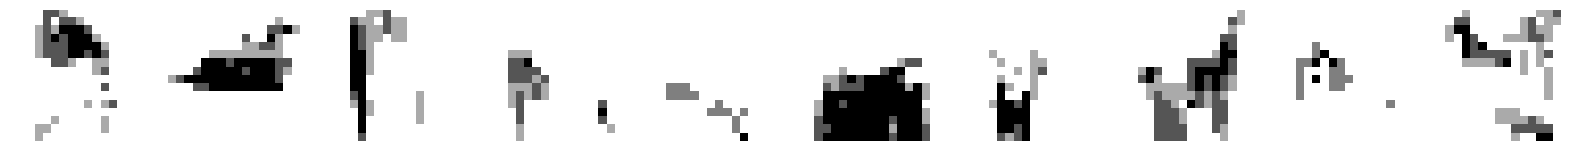

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 135s 67ms/step - loss: 0.5239
Epoch 2/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3966
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_001.png


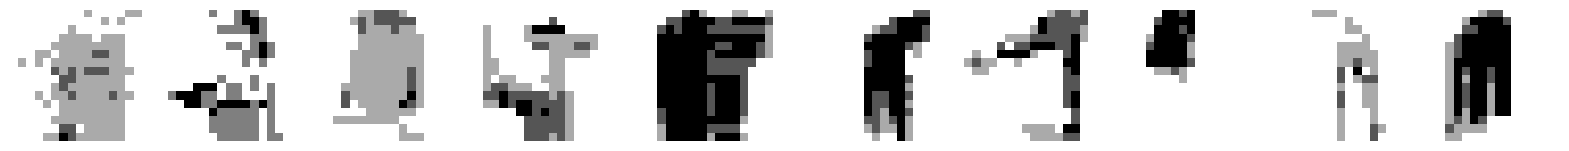

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 134s 72ms/step - loss: 0.3966
Epoch 3/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3846
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_002.png


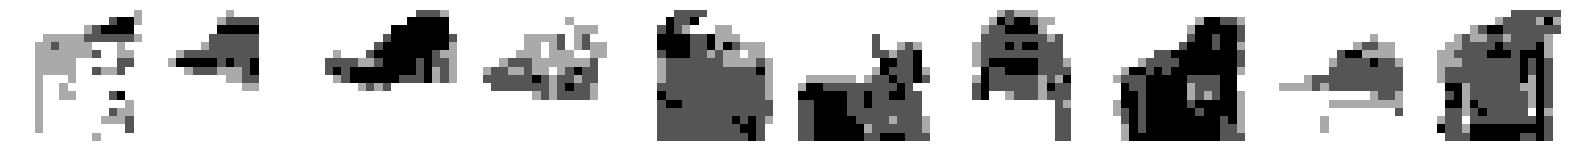

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 119s 64ms/step - loss: 0.3845
Epoch 4/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3795
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_003.png


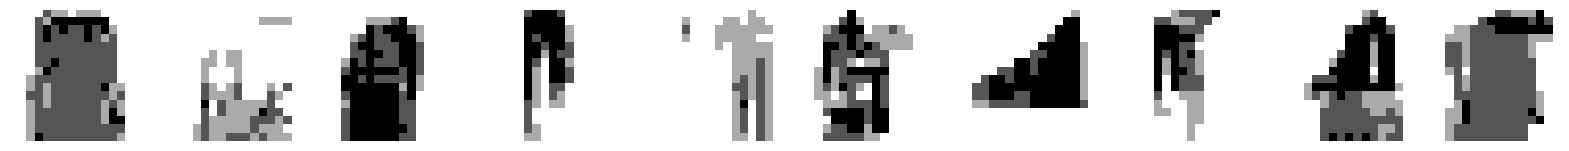

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 145s 77ms/step - loss: 0.3795
Epoch 5/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3757
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_004.png


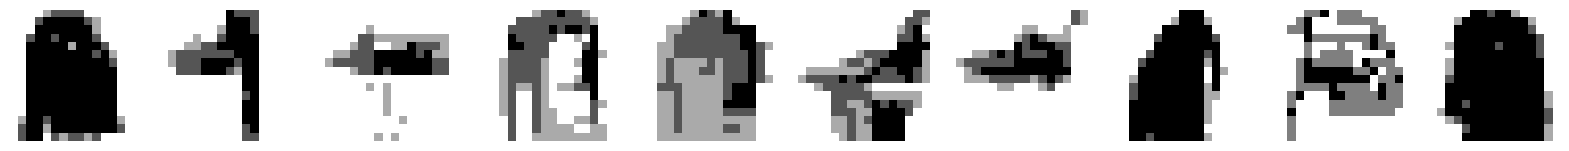

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 133s 71ms/step - loss: 0.3757
Epoch 6/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3712
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_005.png


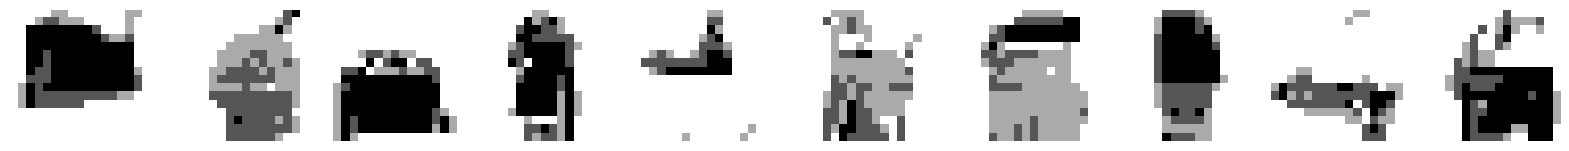

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 126s 67ms/step - loss: 0.3712
Epoch 7/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3686
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_006.png


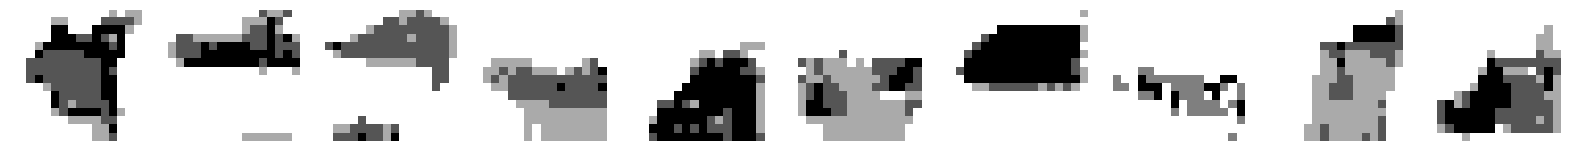

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3686
Epoch 8/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3659
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_007.png


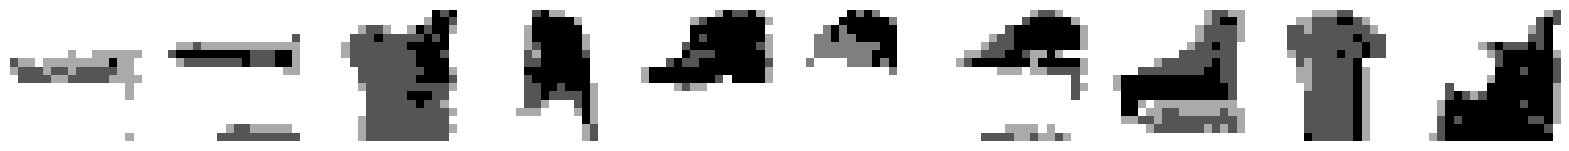

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3659
Epoch 9/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3636
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_008.png


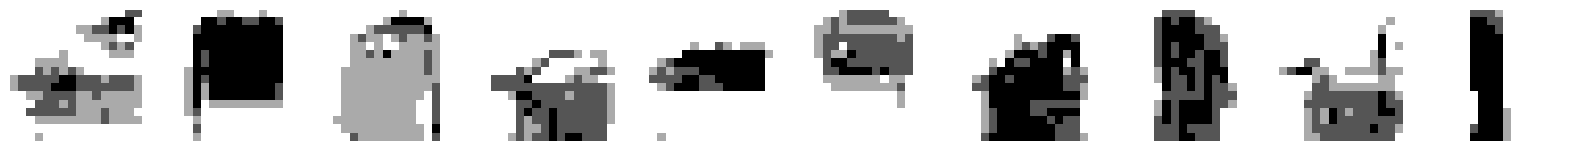

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 65ms/step - loss: 0.3636
Epoch 10/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3613
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_009.png


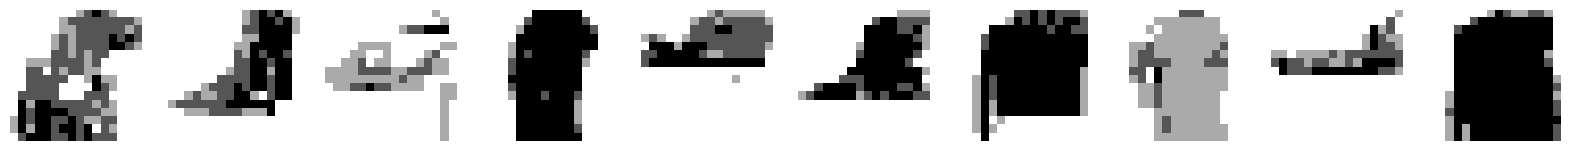

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - loss: 0.3613
Epoch 11/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3605
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_010.png


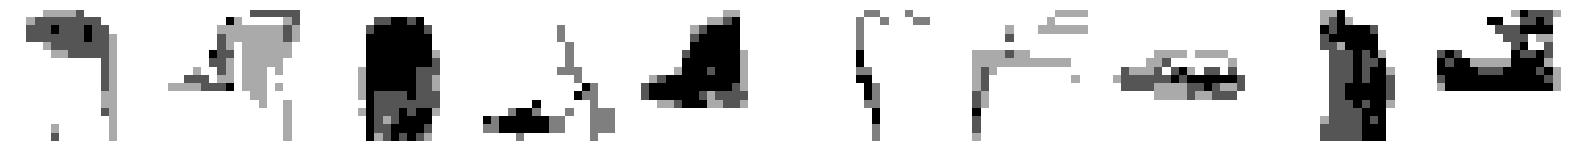

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 64ms/step - loss: 0.3605
Epoch 12/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3592
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_011.png


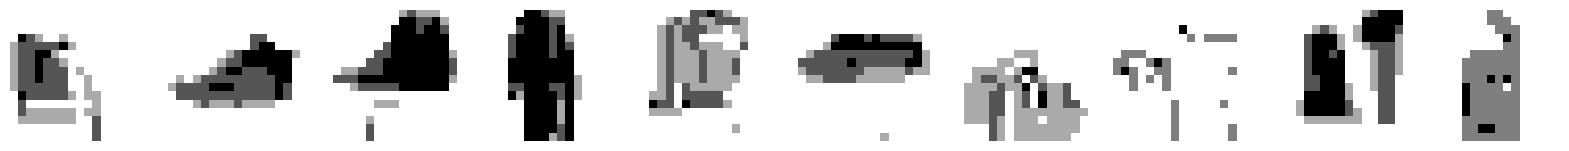

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 64ms/step - loss: 0.3592
Epoch 13/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3580
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_012.png


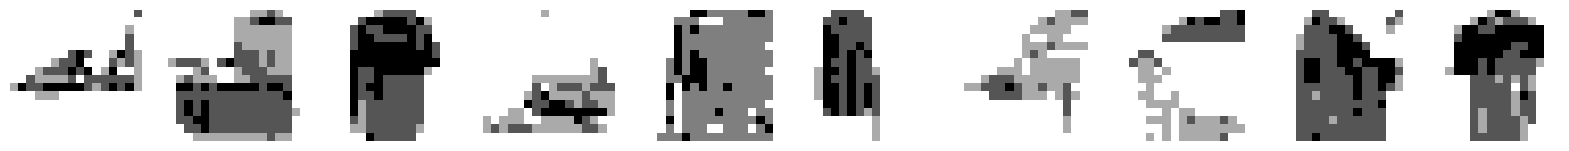

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3580
Epoch 14/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3574
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_013.png


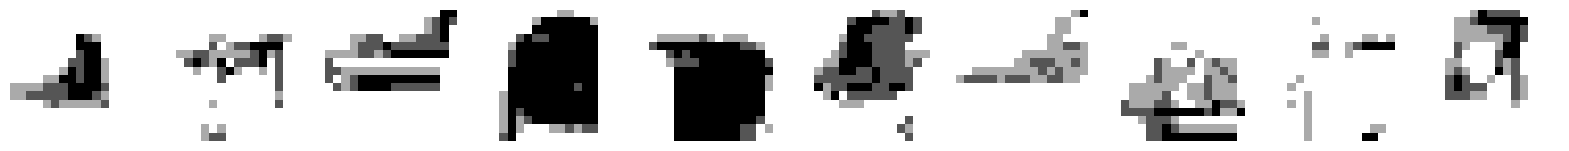

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 64ms/step - loss: 0.3574
Epoch 15/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3562
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_014.png


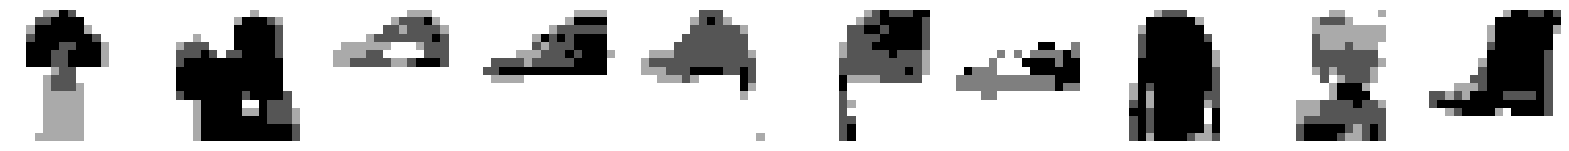

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3562
Epoch 16/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3562
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_015.png


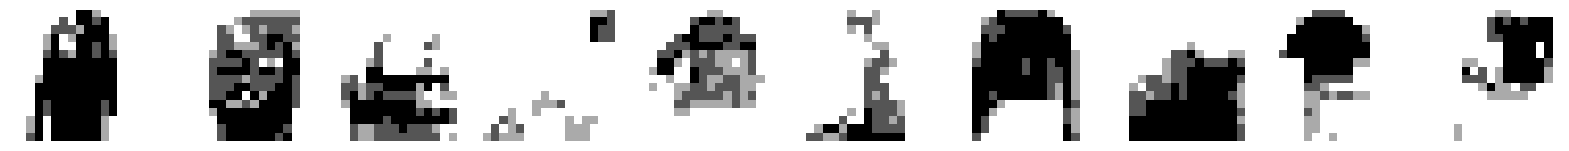

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3562
Epoch 17/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3547
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_016.png


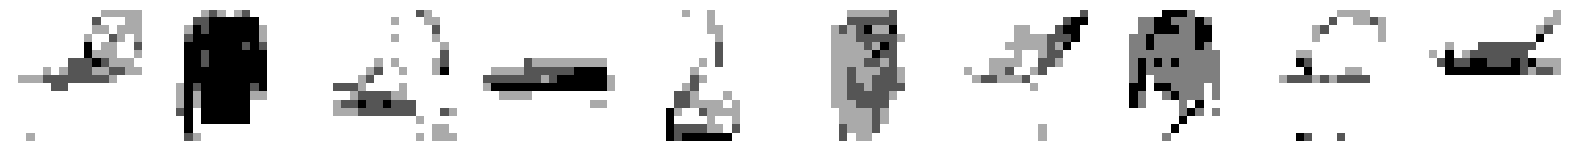

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - loss: 0.3547
Epoch 18/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3545
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_017.png


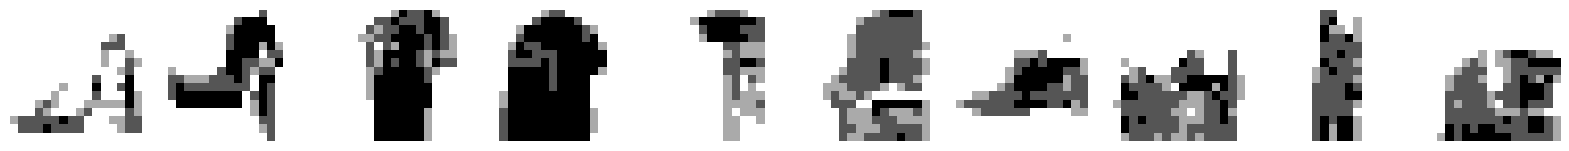

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3545
Epoch 19/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3540
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_018.png


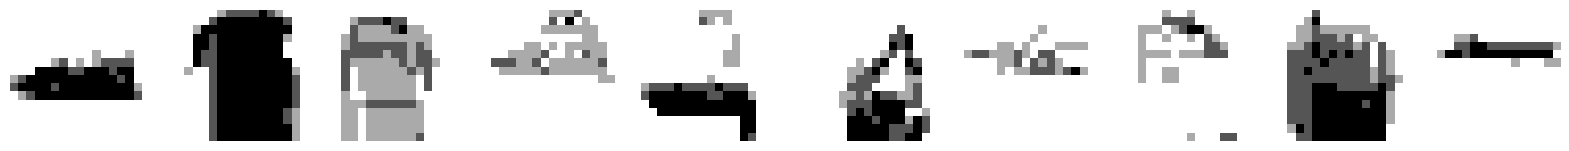

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 65ms/step - loss: 0.3540
Epoch 20/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3533
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_019.png


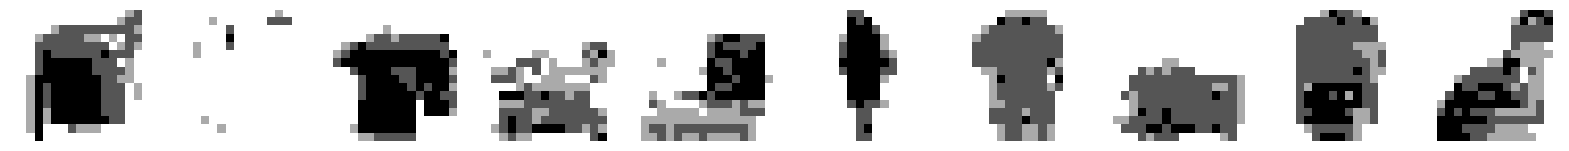

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3533
Epoch 21/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3521
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_020.png


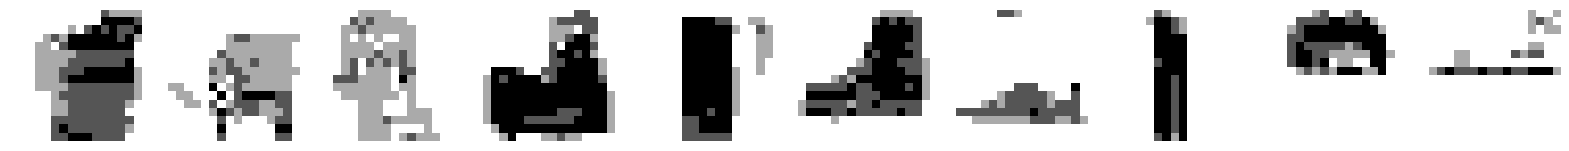

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 63ms/step - loss: 0.3521
Epoch 22/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3523
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_021.png


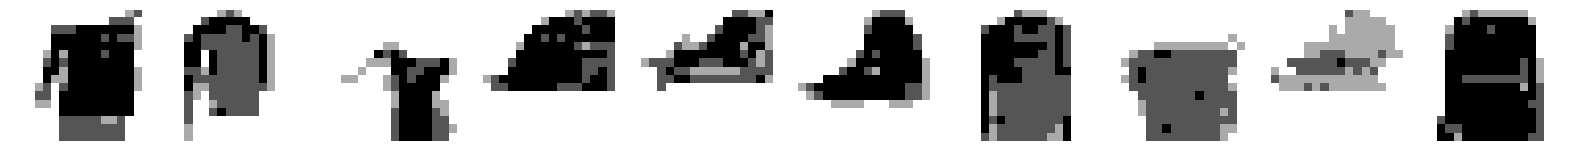

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - loss: 0.3523
Epoch 23/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3515
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_022.png


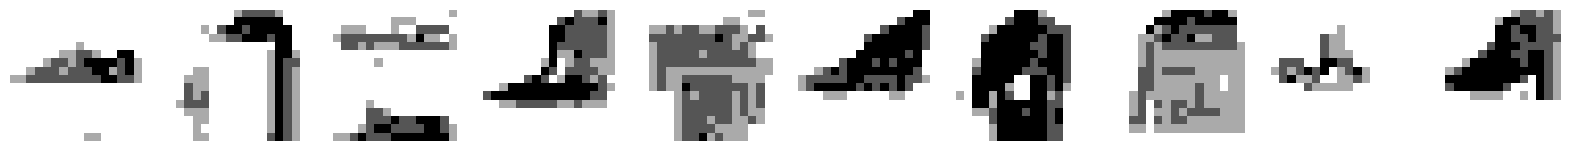

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - loss: 0.3515
Epoch 24/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3515
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_023.png


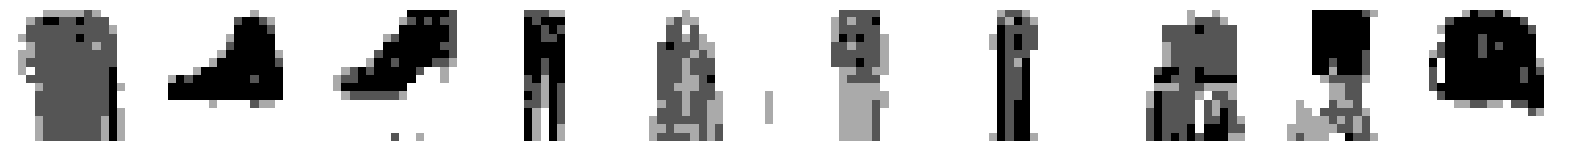

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3515
Epoch 25/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3492
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_024.png


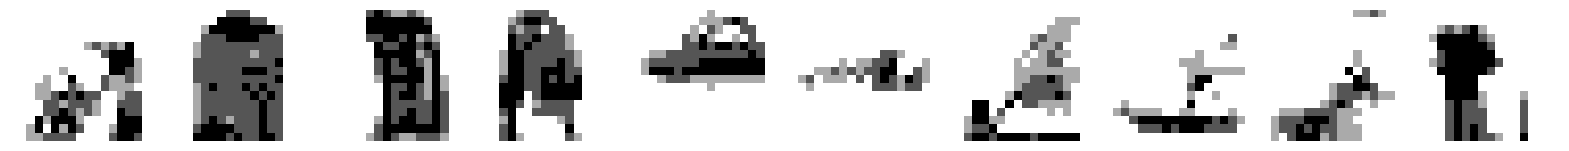

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3492
Epoch 26/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3508
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_025.png


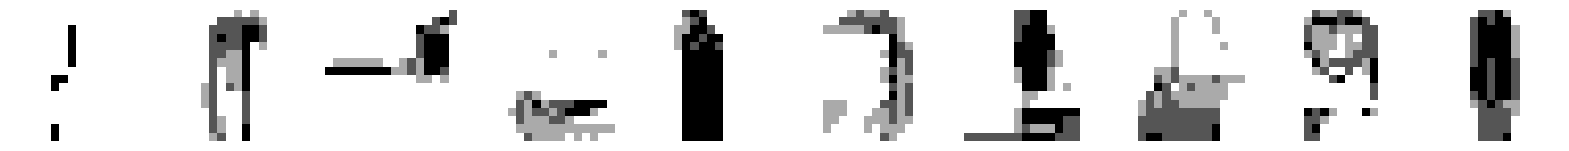

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3508
Epoch 27/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3497
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_026.png


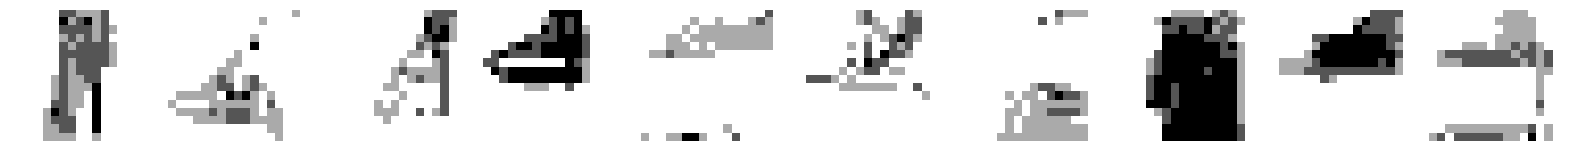

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - loss: 0.3497
Epoch 28/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3490
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_027.png


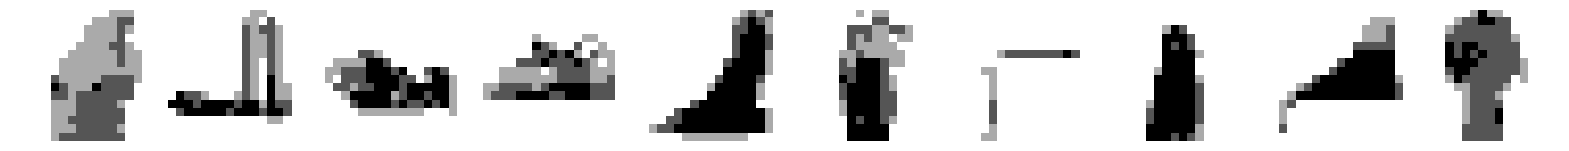

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 65ms/step - loss: 0.3490
Epoch 29/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3494
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_028.png


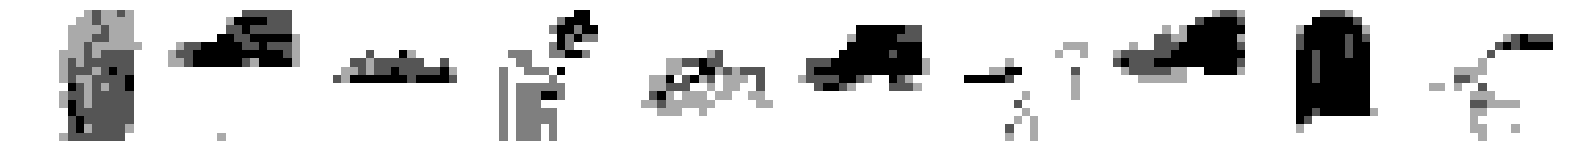

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 125s 67ms/step - loss: 0.3494
Epoch 30/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3501
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_029.png


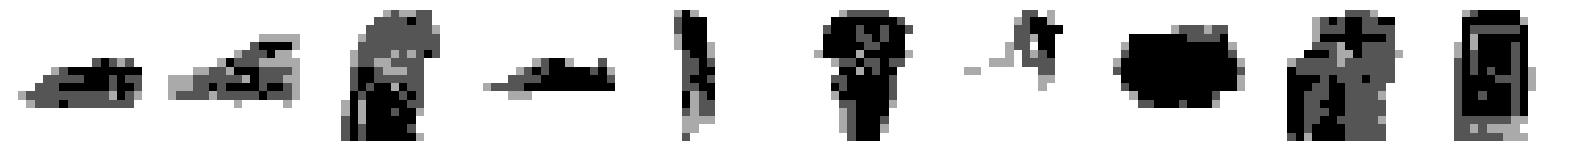

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - loss: 0.3501
Epoch 31/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3493
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_030.png


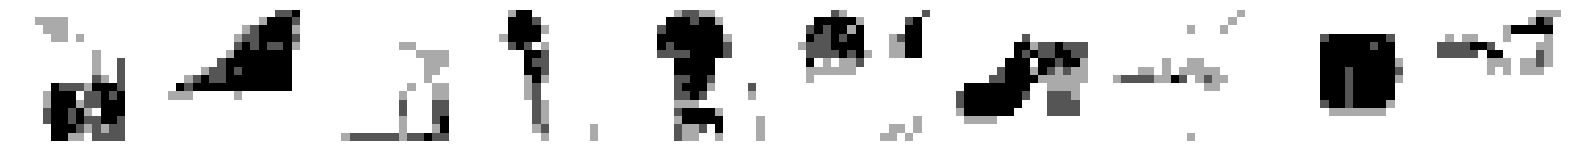

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 65ms/step - loss: 0.3493
Epoch 32/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3489
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_031.png


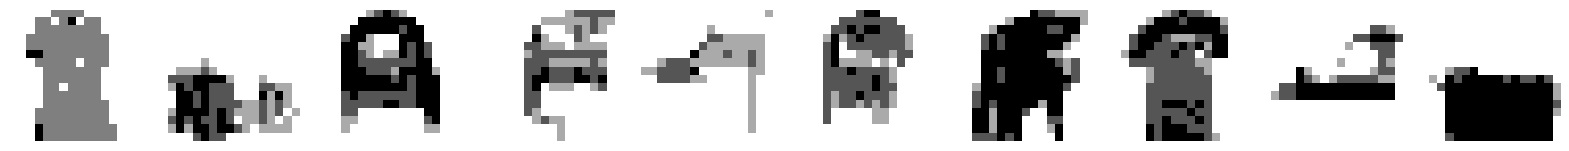

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3489
Epoch 33/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3480
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_032.png


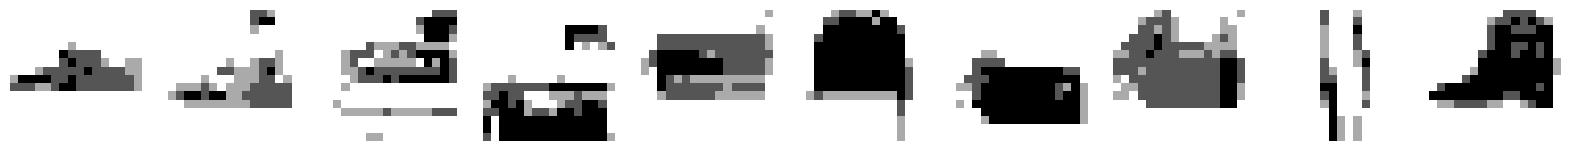

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3480
Epoch 34/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3483
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_033.png


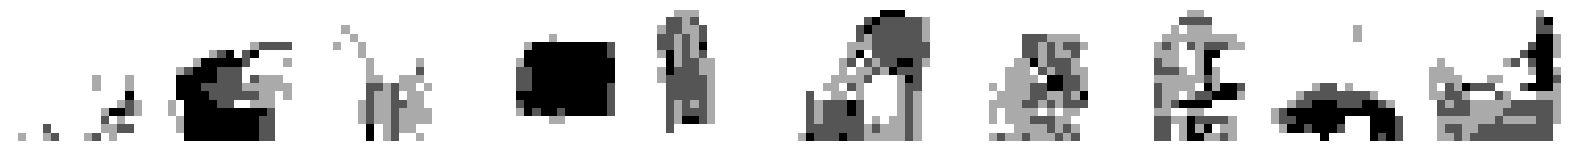

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 64ms/step - loss: 0.3483
Epoch 35/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3480
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_034.png


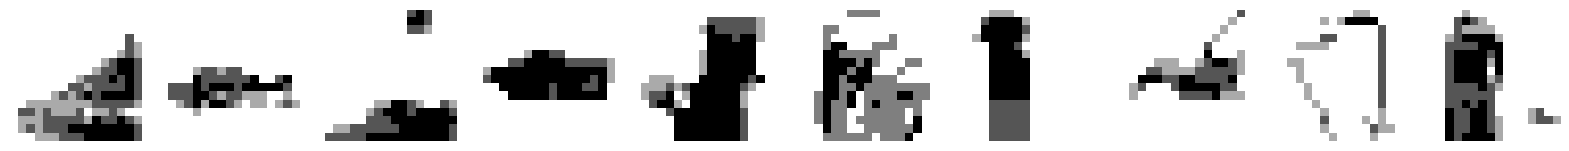

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3480
Epoch 36/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3476
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_035.png


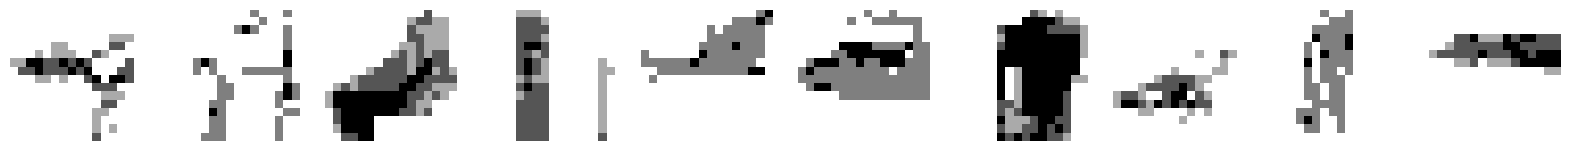

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 70ms/step - loss: 0.3476
Epoch 37/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3484
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_036.png


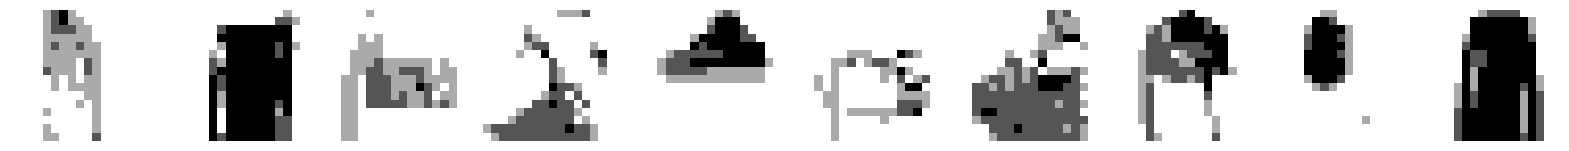

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3484
Epoch 38/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3475
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_037.png


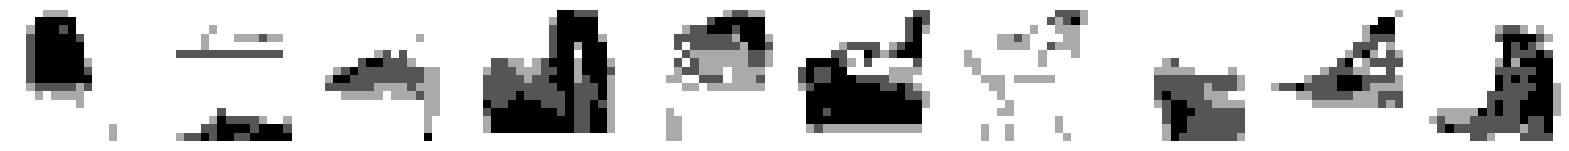

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - loss: 0.3475
Epoch 39/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3470
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_038.png


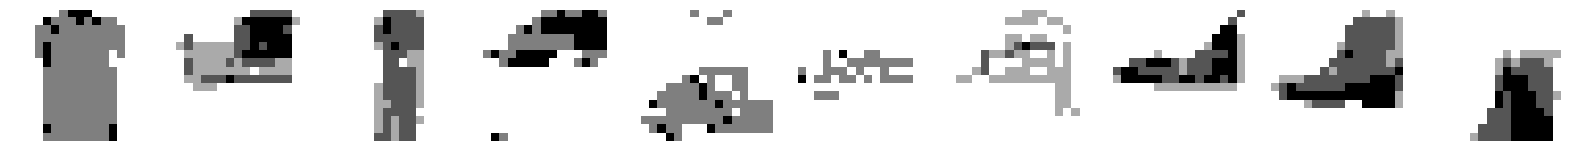

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - loss: 0.3470
Epoch 40/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3472
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_039.png


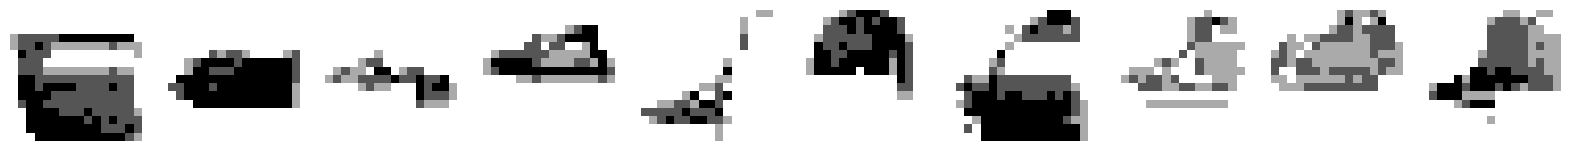

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - loss: 0.3472
Epoch 41/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3468
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_040.png


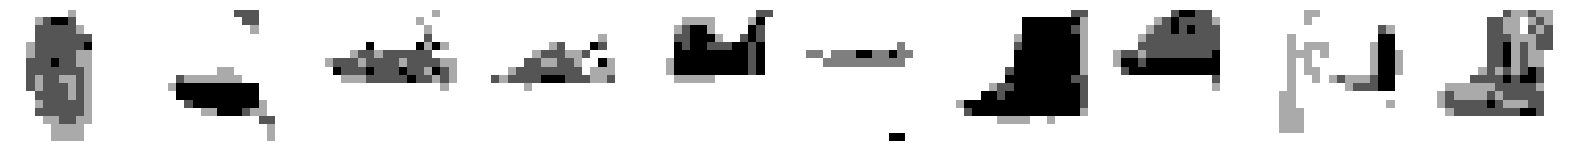

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3468
Epoch 42/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3470
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_041.png


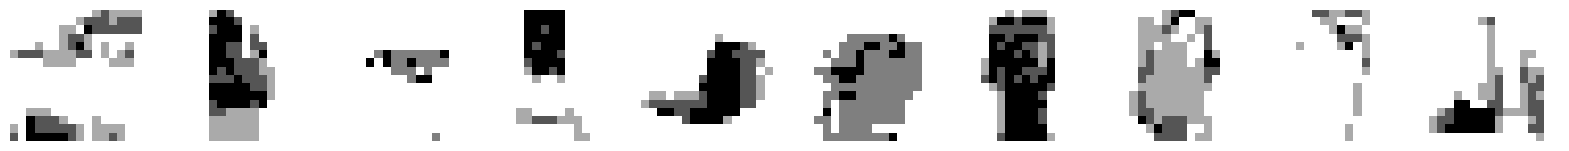

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3470
Epoch 43/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3463
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_042.png


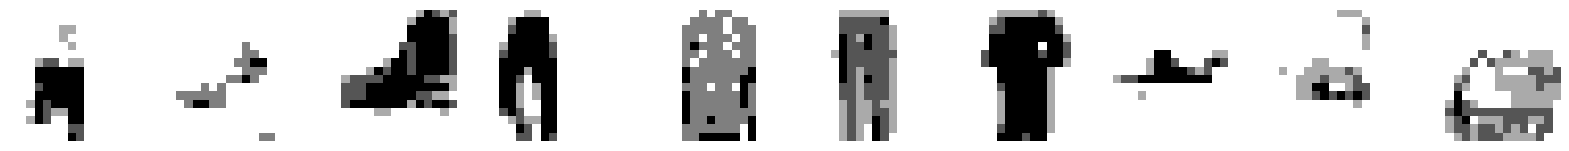

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 63ms/step - loss: 0.3463
Epoch 44/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3464
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_043.png


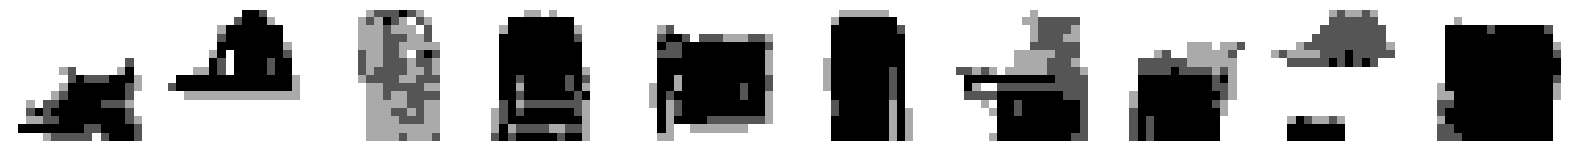

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - loss: 0.3464
Epoch 45/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3462
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_044.png


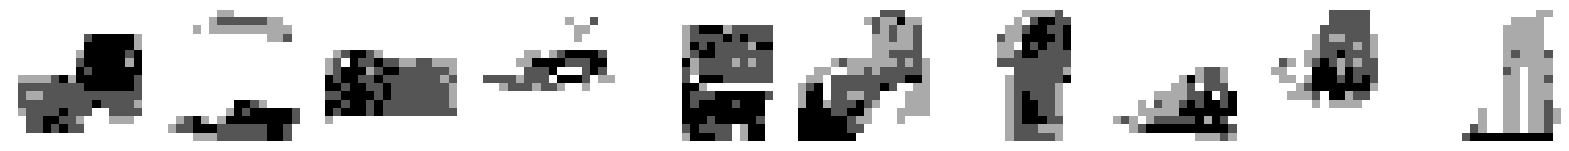

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 115s 61ms/step - loss: 0.3462
Epoch 46/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3467
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_045.png


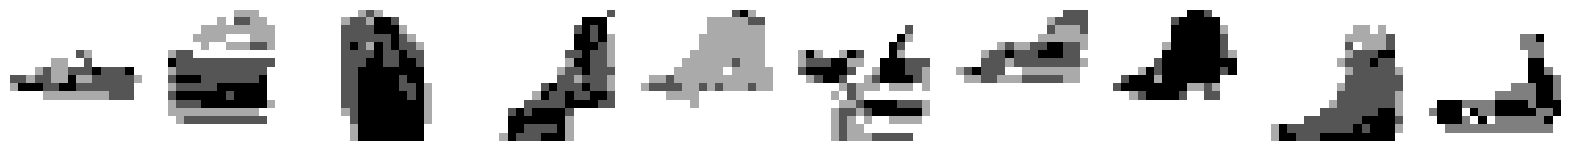

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 134s 71ms/step - loss: 0.3467
Epoch 47/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3453
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_046.png


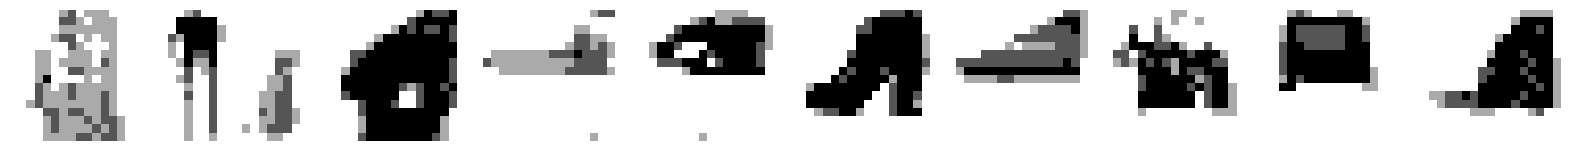

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - loss: 0.3453
Epoch 48/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3463
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_047.png


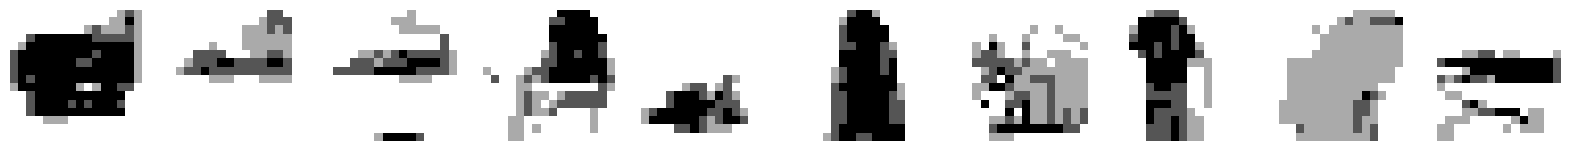

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 75ms/step - loss: 0.3463
Epoch 49/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3454
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_048.png


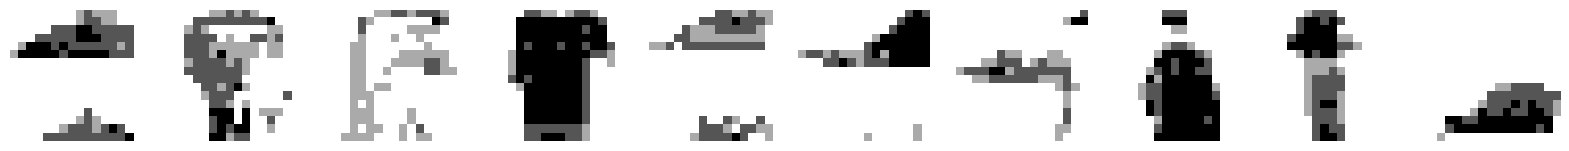

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 158s 84ms/step - loss: 0.3454
Epoch 50/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3455
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_049.png


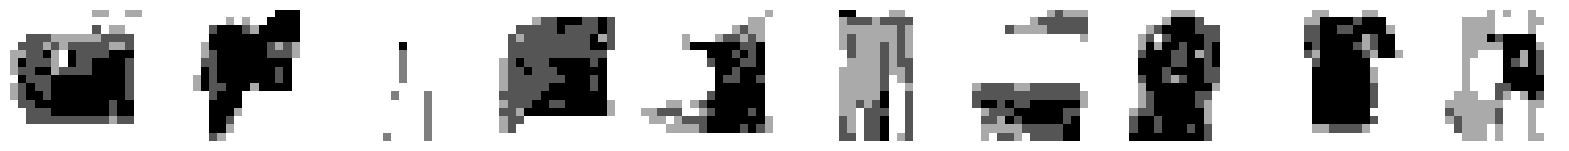

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 166s 89ms/step - loss: 0.3455
Epoch 51/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3451
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_050.png


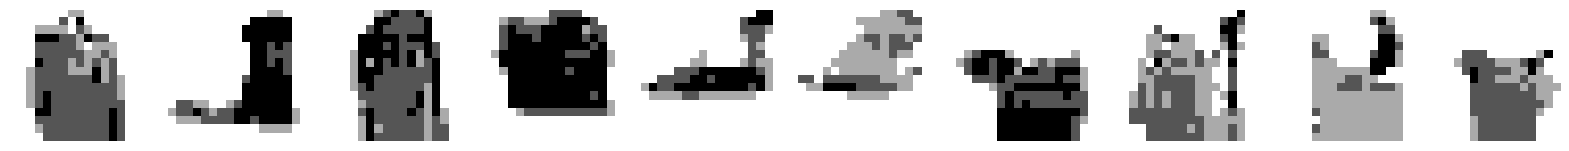

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 145s 77ms/step - loss: 0.3451
Epoch 52/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3460
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_051.png


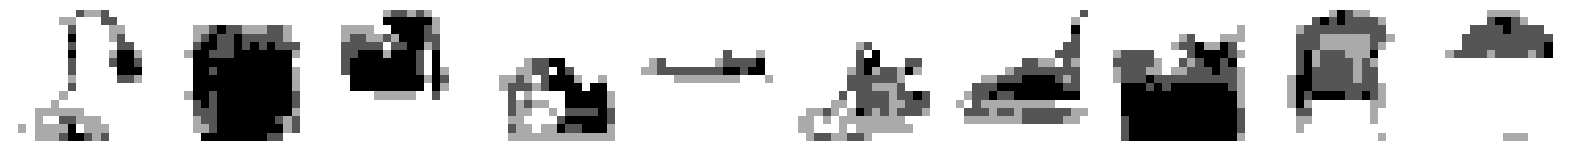

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - loss: 0.3460
Epoch 53/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3451
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_052.png


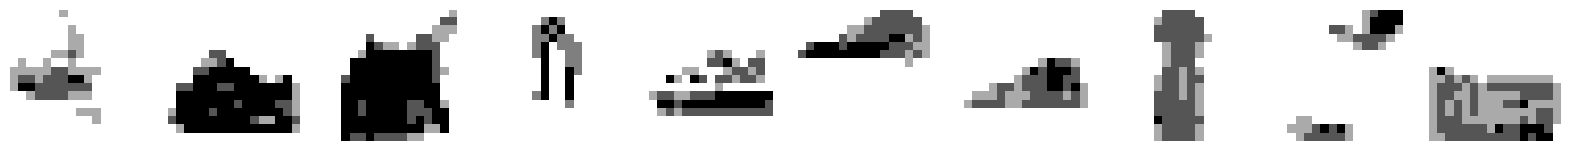

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3451
Epoch 54/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3456
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_053.png


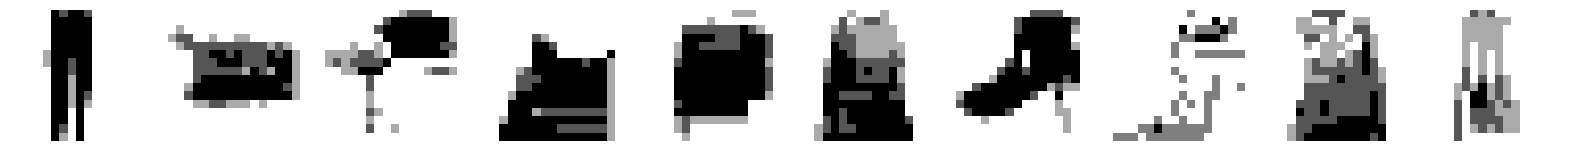

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3456
Epoch 55/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3444
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_054.png


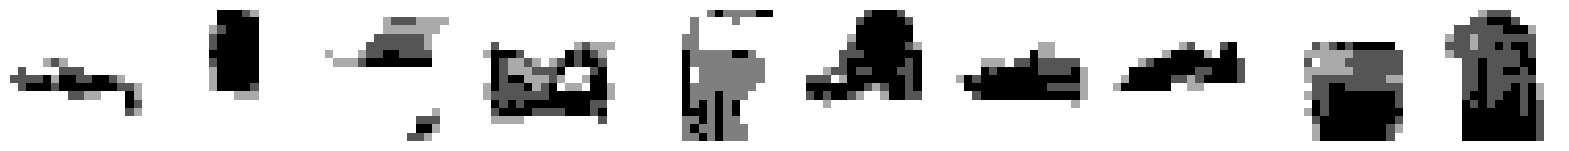

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3444
Epoch 56/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3442
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_055.png


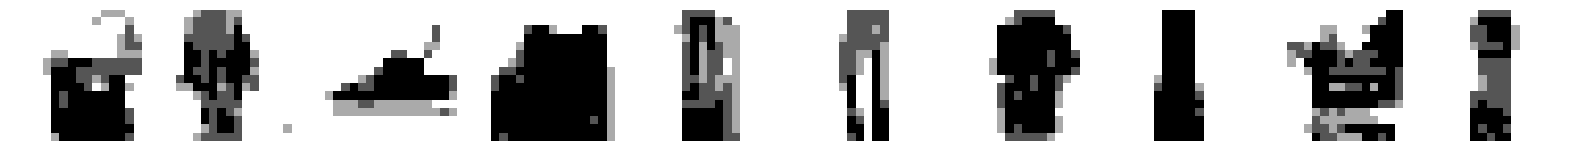

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 65ms/step - loss: 0.3442
Epoch 57/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3451
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_056.png


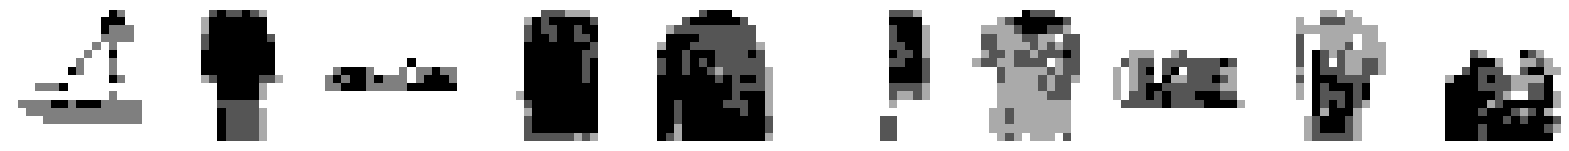

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 134s 71ms/step - loss: 0.3451
Epoch 58/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3441
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_057.png


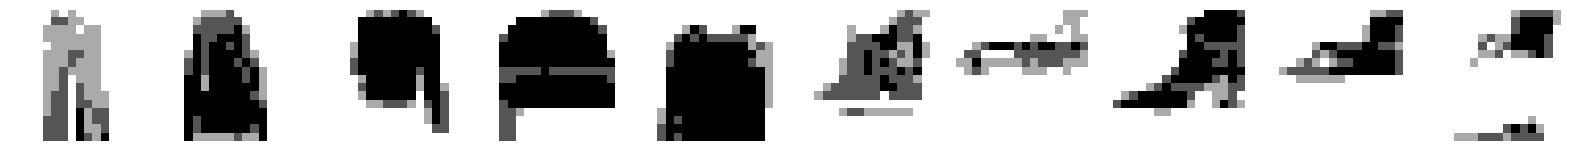

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 128s 68ms/step - loss: 0.3441
Epoch 59/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3449
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_058.png


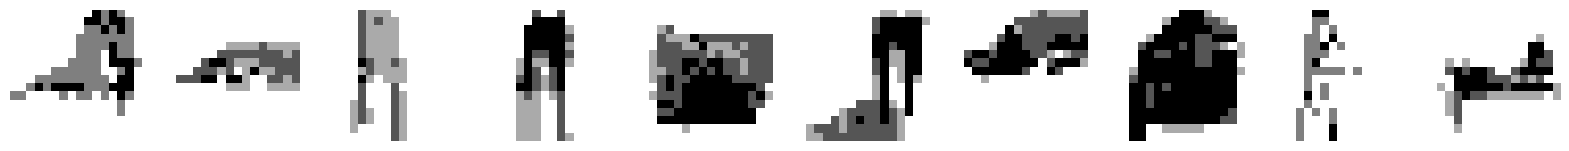

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 128s 68ms/step - loss: 0.3449
Epoch 60/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3437
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_059.png


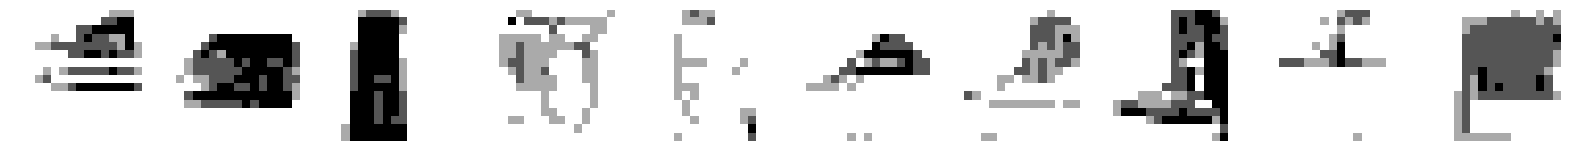

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3437
Epoch 61/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3440
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_060.png


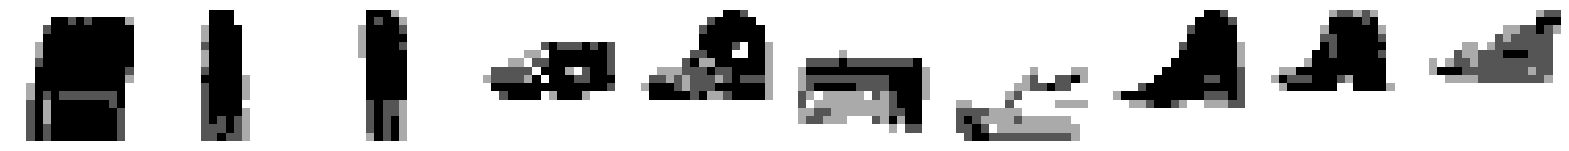

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step - loss: 0.3440
Epoch 62/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3448
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_061.png


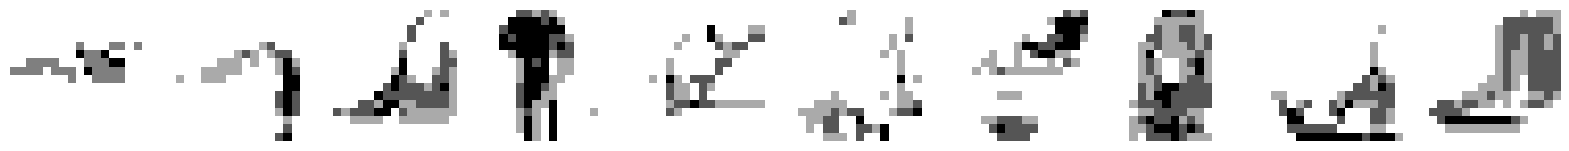

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3448
Epoch 63/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3440
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_062.png


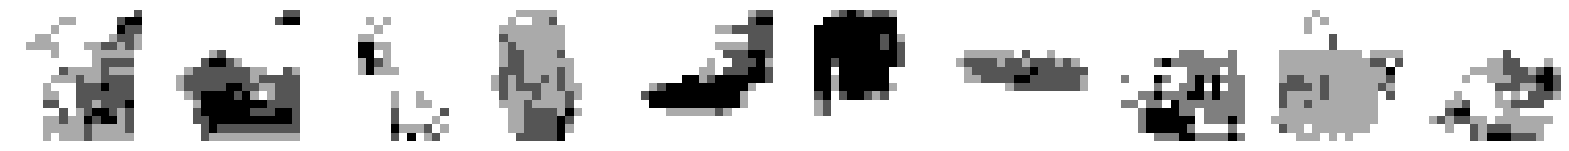

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 114s 61ms/step - loss: 0.3440
Epoch 64/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3453
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_063.png


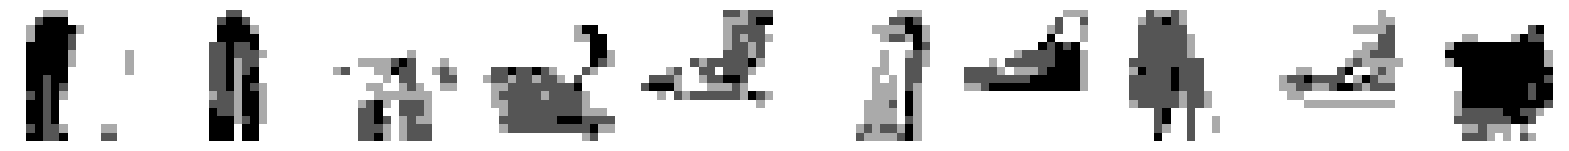

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3453
Epoch 65/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3441
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_064.png


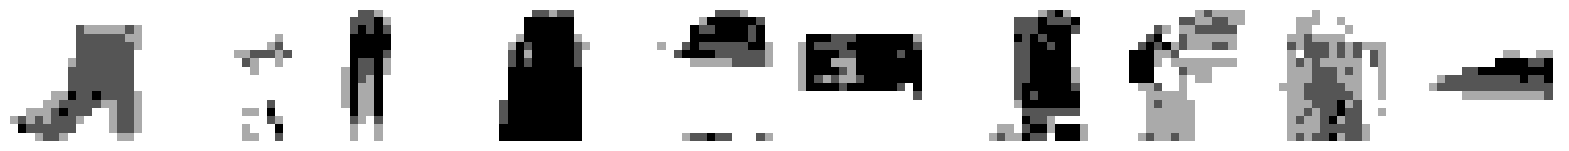

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 63ms/step - loss: 0.3441
Epoch 66/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3439
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_065.png


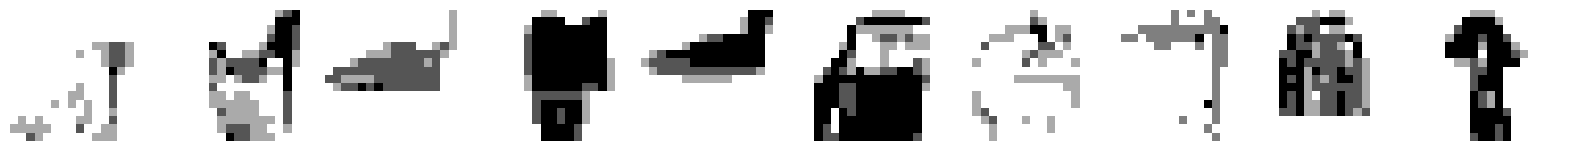

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 65ms/step - loss: 0.3439
Epoch 67/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3432
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_066.png


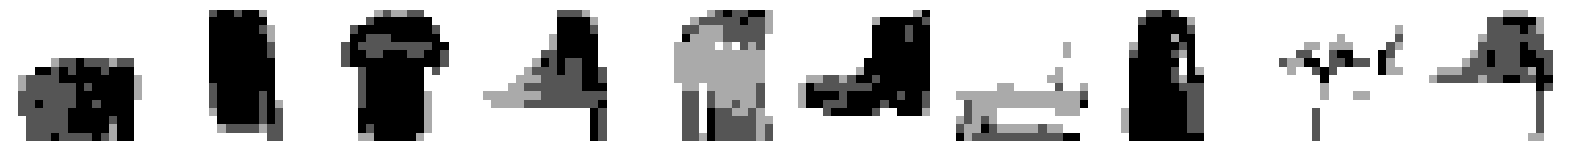

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 116s 62ms/step - loss: 0.3432
Epoch 68/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3431
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_067.png


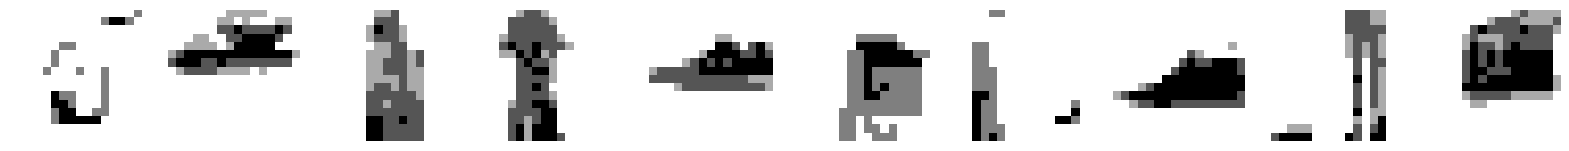

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - loss: 0.3431
Epoch 69/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3431
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_068.png


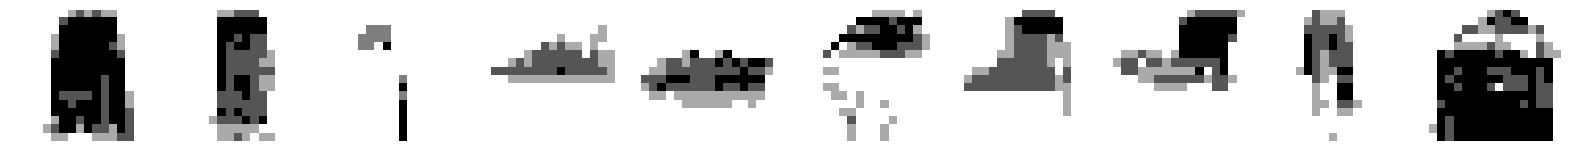

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3431
Epoch 70/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3441
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_069.png


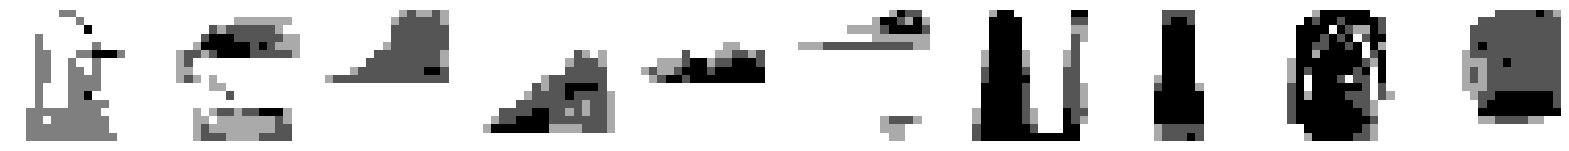

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - loss: 0.3441
Epoch 71/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3441
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_070.png


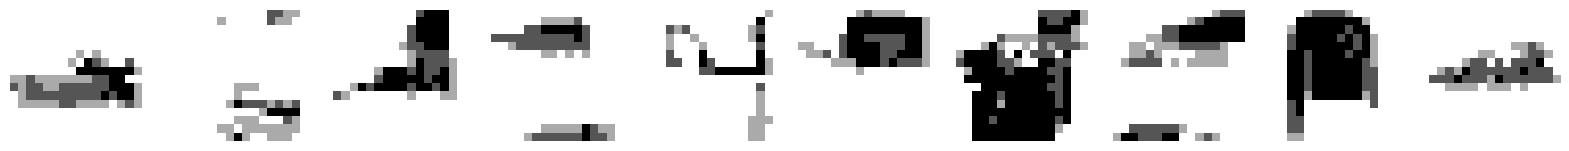

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 126s 67ms/step - loss: 0.3441
Epoch 72/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3442
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_071.png


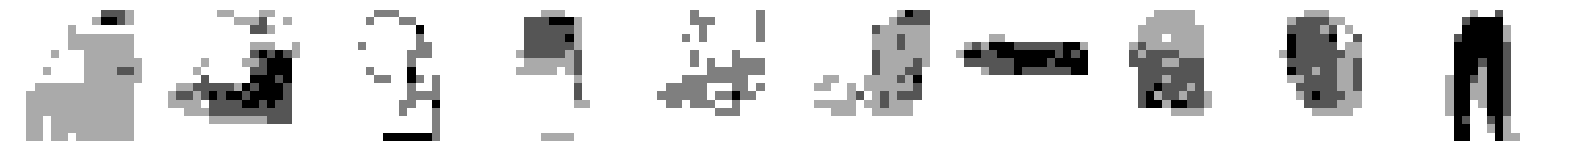

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3442
Epoch 73/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3432
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_072.png


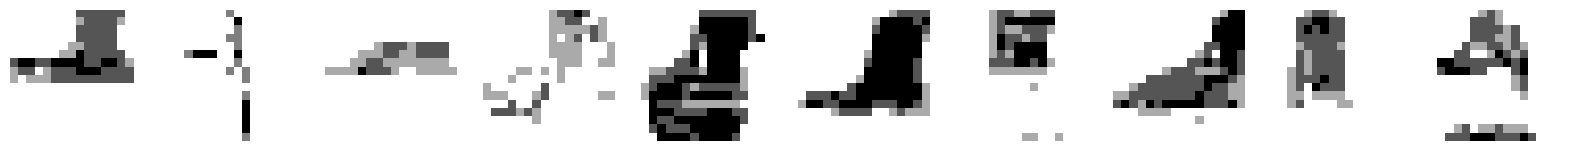

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3432
Epoch 74/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3440
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_073.png


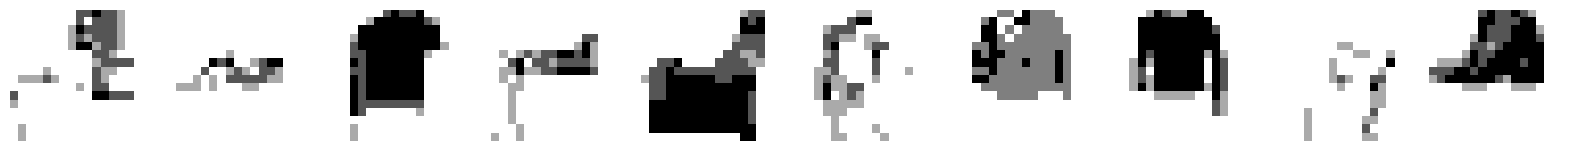

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 65ms/step - loss: 0.3440
Epoch 75/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3434
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_074.png


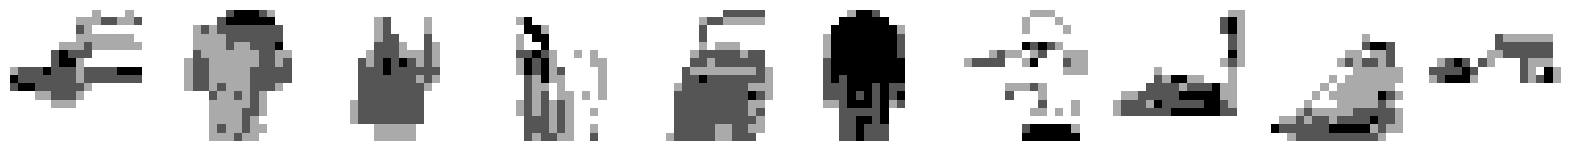

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 63ms/step - loss: 0.3434
Epoch 76/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3425
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_075.png


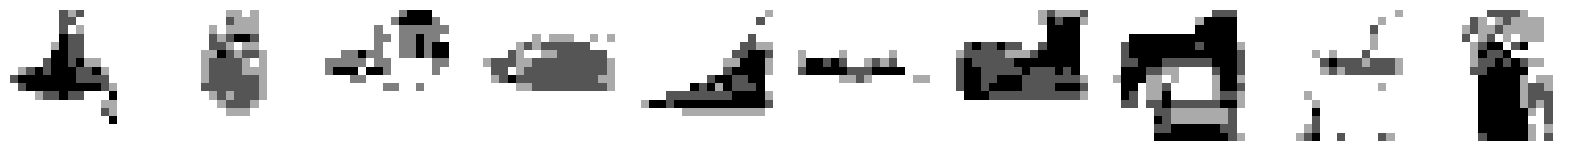

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 114s 61ms/step - loss: 0.3425
Epoch 77/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3432
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_076.png


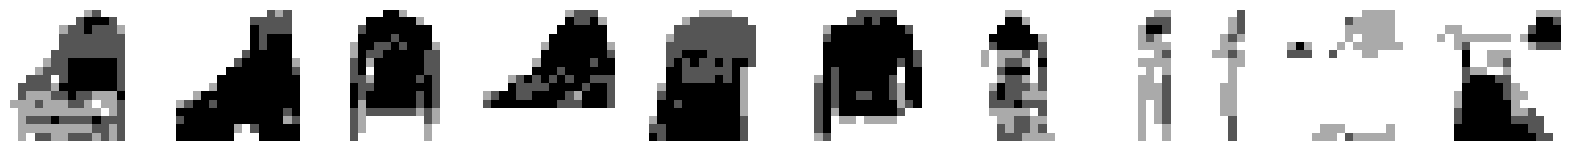

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.3432
Epoch 78/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3427
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_077.png


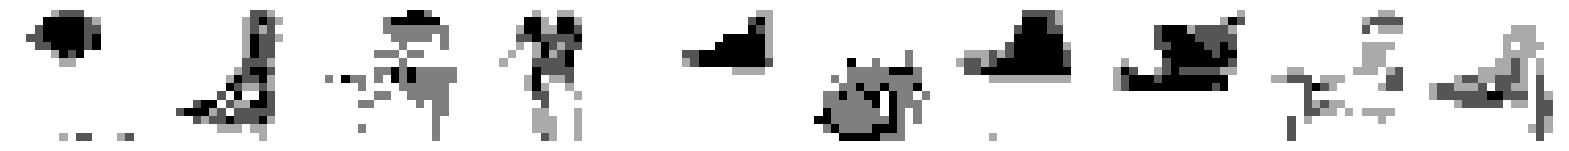

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - loss: 0.3427
Epoch 79/80
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3422
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_078.png


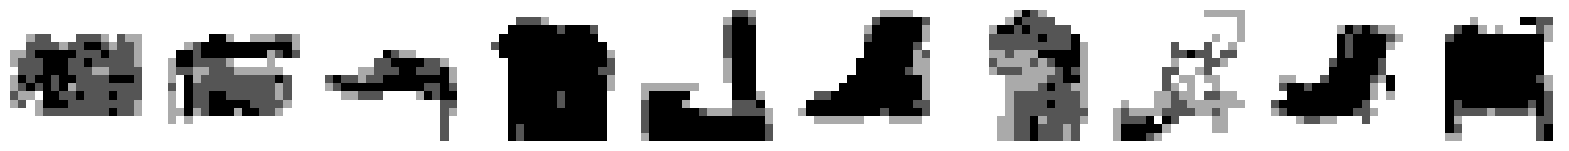

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 119s 64ms/step - loss: 0.3422
Epoch 80/80
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3427
Saved to C:\Users\rohit\OneDrive\AIML_Journey\pixelcnn_output\gen_image_079.png


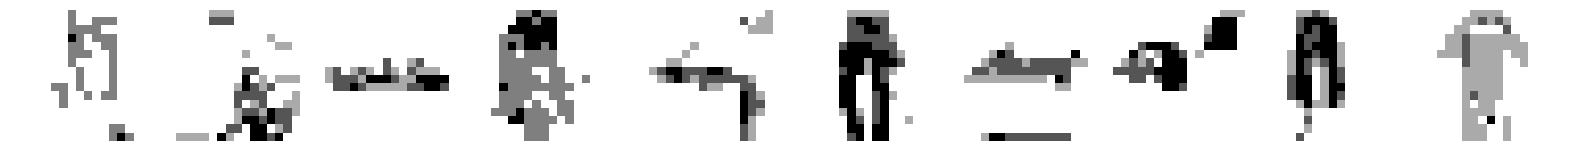

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 122s 65ms/step - loss: 0.3427


In [65]:
p_cnn_model.fit(train_x,train_y,batch_size = 32, epochs=EPOCHS,callbacks=[ImageGenerator()])